In [29]:
# main import
import sys
import os
import json
import nltk
import numpy as np
import pandas as pd

# analytics import
sys.path.append('..')
from preprocess import MediumBlogPost

# utils import
from utils import parse_date, get_word_count

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

# visualization imports
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline


files = ['data-science.jl', 'startup.jl']

## load data

In [2]:
dfs = []
for file_name in files:
    file_path = os.path.join(os.environ['RAW_DATA_PATH'], file_name)
    with open(file_path) as f:
        for line in f:
            # get raw data
            row = MediumBlogPost(**json.loads(line)).to_frame()
            dfs.append(row)

df = pd.concat(dfs).reset_index(drop=True)

In [3]:
df.head(5)

,title,publish_time,author,url,author_url,headings,contents,mins_read,claps,lang,tags
0,The Woman Behind the Data – Data Wonderment – ...,2018-01-01,Data Wonderment,https://medium.com/@datawonderment/the-woman-b...,https://medium.com/@datawonderment,The Woman Behind the Data,"October 2, 2017 By Ashley Albers Often we see ...",2,0,en,"[Data, Datascience, Orlando]"
1,CoreML — Building the model for Boston Prices ...,2018-01-01,Dr J Rogel-Salazar,https://medium.com/@quantum_tunnel/coreml-buil...,https://medium.com/@quantum_tunnel,CoreML — Building the model for Boston Prices ...,In the last post we have taken a look at the ...,3,1,en,"[Coreml, Data Science, iOS, Machine Learning, ..."
2,TRANSFER LEARNING DEMYSTIFIED – Najeeb Khan – ...,2018-01-01,Najeeb Khan,https://medium.com/@najeebnik21/transfer-learn...,https://medium.com/@najeebnik21,Let us understand transfer learning concept fr...,TRANSFER LEARNING DEMYSTIFIED What is Transfer...,4,1,en,"[Machine Learning, Data Science, Artificial In..."
3,Autonomous Data as a Beginner – Data Autonomy ...,2018-01-01,Kevin Kautz,https://medium.com/data-autonomy/autonomous-da...,https://medium.com/@kevin642,Autonomous Data as a Beginner,Professor Peter J. Denning published an articl...,2,0,en,"[Artificial Intelligence, Data, Analytics, Dat..."
4,How Timing Can Affect Your New Years Resolutio...,2018-01-01,Matthew Amsden,https://medium.com/proofpilot/can-timing-can-a...,https://medium.com/@matthewamsden,How Timing Can Affect Your New Years Resolutio...,"As the calendar turns to a new year, as is tra...",3,0,en,"[Health, Wellness, Research, Data Science, New..."


## feature engineering

Base on Model V1.0 result, we think there are still plenty of room for improvement. <br/>
We can do followings to improve results


1. remove year, month, day
2. add unique word count in title
3. add unique word count in headings
4. add unique word count in contents
5. add target encodings (claps average, claps std) of tags

NOTE:
1. feature eng items 1 to 5 are agnostic to future data
2. feature eng item 5 would potentially lead to data leakage if not handle properly, we should use hashing technique

## data down-sampling
We have observed that there are many blogs with zero clap, these samples will heavily affect linear models performance, they would cause residuals skewed to one side. Meanwhile, clap of zero is the lowest value in targets but also are the majority of tagets, which means those points have high leverage in linear modeling but we cares more on blogs with higher values of claps. So we need to down-sample (remove) samples with claps < 5

### part i

In [14]:
# # 2. title wc
# df_title_wc = get_word_count(df.title)
# # 3. headings wc
# df_headings_wc = get_word_count(df.headings)
# # 4. contents wc
# df_contents_wc = get_word_count(df.contents)

In [3]:
# # save data
# df_features = pd.concat(
#     [
#         df_title_wc,
#         df_headings_wc,
#         df_contents_wc,
#         df.author,
#         df.mins_read,
#         df.tags,
#     ],
#     axis=1
# )
# df_features.to_pickle('../data/features_V11.pkl')

In [4]:
df_features = pd.read_pickle('../data/features_V11.pkl')

In [5]:
df_features.head()

,title_word_count,title_unique_word_count,title_stopword_count,title_unusual_word_count,title_total_word_count,headings_word_count,headings_unique_word_count,headings_stopword_count,headings_unusual_word_count,headings_total_word_count,contents_word_count,contents_unique_word_count,contents_stopword_count,contents_unusual_word_count,contents_total_word_count,author,mins_read,tags
0,6,8,2,2,10,3,5,2,0,5,174,260,269,127,570,Data Wonderment,2,"[Data, Datascience, Orlando]"
1,5,13,2,7,14,4,9,2,4,10,152,202,191,95,438,Dr J Rogel-Salazar,3,"[Coreml, Data Science, iOS, Machine Learning, ..."
2,4,7,0,4,8,21,26,7,6,34,324,311,338,152,814,Najeeb Khan,4,"[Machine Learning, Data Science, Artificial In..."
3,6,8,2,2,10,3,5,2,0,5,126,199,224,93,443,Kevin Kautz,2,"[Artificial Intelligence, Data, Analytics, Dat..."
4,4,14,5,5,14,4,14,5,5,14,306,396,357,242,905,Matthew Amsden,3,"[Health, Wellness, Research, Data Science, New..."


## train / test split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    df_features.copy(),
    df.claps.copy(),
    test_size=0.2,
    random_state=99)

print(X_train.shape, X_test.shape)

(20016, 18) (5005, 18)


### part ii

In [7]:
# get a author: n blogs lookup table
author_to_nblogs = X_train['author'].groupby(X_train['author']).count().to_dict()

# add to X_train
nblogs = X_train.author.map(author_to_nblogs)
X_train.loc[nblogs.index, 'nblogs'] = nblogs
# add to X_test
nblogs = X_test.author.map(author_to_nblogs).fillna(0)
X_test.loc[nblogs.index, 'nblogs'] = nblogs

# aggs
aggs = ['mean', 'median', 'max', 'min']

# get a author: claps agg lookup table
author_to_claps_agg = y_train.groupby(X_train['author']).agg(aggs).to_dict()
for method in aggs:
    # add to X_train
    agg_stat = X_train.author.map(author_to_claps_agg[method])
    X_train.loc[agg_stat.index, 'claps_{}_by_author'.format(method)] = agg_stat
    # add to X_test
    agg_stat = X_test.author.map(author_to_claps_agg[method]).fillna(0)
    X_test.loc[agg_stat.index, 'claps_{}_by_author'.format(method)] = agg_stat



# get a tags: claps agg lookup table 
train_tags = X_train['tags'].apply(pd.Series).stack().reset_index(level=1, drop=True)
test_tags = X_test['tags'].apply(pd.Series).stack().reset_index(level=1, drop=True)
tags_to_claps_agg = y_train.loc[train_tags.index] \
    .groupby(train_tags) \
    .agg(aggs).to_dict()
for method in aggs:
    # add to X_train
    agg_stat = train_tags.map(tags_to_claps_agg[method]).groupby(level=0).mean()
    X_train.loc[agg_stat.index, 'claps_{}_by_tags'.format(method)] = agg_stat
    X_train['claps_{}_by_tags'.format(method)].fillna(0, inplace=True)
    # add to X_test
    agg_stat = test_tags.map(tags_to_claps_agg[method]).fillna(0).groupby(level=0).mean()
    X_test.loc[agg_stat.index, 'claps_{}_by_tags'.format(method)] = agg_stat
    X_test['claps_{}_by_tags'.format(method)].fillna(0, inplace=True)

# drop cols
X_train.drop(['tags', 'author'], axis=1, inplace=True)
X_test.drop(['tags', 'author'], axis=1, inplace=True)

print(X_train.shape, X_test.shape)

(20016, 25) (5005, 25)


## some inspection

In [8]:
pd.set_option('display.max_columns', 30)
X_train.describe()

,title_word_count,title_unique_word_count,title_stopword_count,title_unusual_word_count,title_total_word_count,headings_word_count,headings_unique_word_count,headings_stopword_count,headings_unusual_word_count,headings_total_word_count,contents_word_count,contents_unique_word_count,contents_stopword_count,contents_unusual_word_count,contents_total_word_count,mins_read,nblogs,claps_mean_by_author,claps_median_by_author,claps_max_by_author,claps_min_by_author,claps_mean_by_tags,claps_median_by_tags,claps_max_by_tags,claps_min_by_tags
count,20016.000000,20016.000000,20016.000000,20016.00000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000,20016.000000
mean,4.538669,10.995953,2.714828,4.69984,11.953337,8.254996,17.752998,7.003647,7.172562,22.431205,281.700090,340.338529,340.270933,218.586281,840.557304,4.019285,4.327238,133.294864,111.278827,373.459782,70.290418,146.655773,17.516236,35654.276227,3.606471
std,1.707781,3.000064,2.193446,2.10604,3.149553,12.068972,21.254993,13.205149,11.604224,34.489868,245.481431,208.021491,314.846120,207.046528,746.691295,2.990321,8.344232,1042.736334,926.797538,3097.161407,778.728193,156.729264,78.639027,23585.539189,33.044230
min,0.000000,3.000000,0.000000,0.00000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,17.000000,8.000000,3.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,9.000000,1.000000,3.00000,10.000000,2.000000,5.000000,1.000000,1.000000,5.000000,123.000000,193.000000,138.000000,95.000000,366.000000,2.000000,1.000000,0.500000,0.000000,1.000000,0.000000,77.127343,5.750000,20994.650000,0.000000
50%,4.000000,11.000000,2.000000,5.00000,12.000000,4.000000,11.000000,3.000000,4.000000,11.000000,228.000000,311.500000,268.000000,173.000000,672.000000,3.000000,2.000000,9.000000,5.000000,15.000000,1.000000,116.054513,9.750000,28366.666667,0.000000
75%,6.000000,13.000000,4.000000,6.00000,14.000000,10.000000,23.000000,8.000000,9.000000,27.000000,368.000000,446.000000,451.000000,280.000000,1095.000000,5.000000,4.000000,61.000000,53.000000,99.000000,29.000000,167.436823,18.500000,43019.650000,0.000000
max,12.000000,26.000000,18.000000,33.00000,34.000000,491.000000,491.000000,611.000000,300.000000,1402.000000,4963.000000,3131.000000,7521.000000,4691.000000,16190.000000,53.000000,80.000000,67000.000000,67000.000000,103000.000000,67000.000000,9073.298014,6722.800000,103000.000000,2360.000000


In [9]:
y_train.describe()

count     20016.000000
mean        133.294864
std        1261.098295
min           0.000000
25%           0.000000
50%           5.000000
75%          54.000000
max      103000.000000
Name: claps, dtype: float64

## Down sampling
We like to drop samples with claps < 5

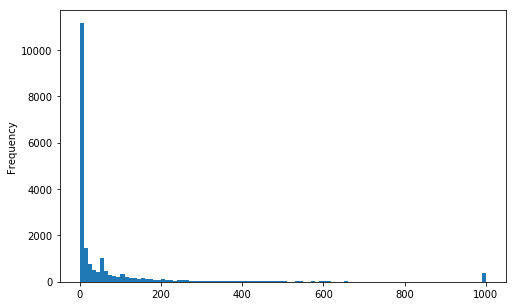

In [10]:
# outcome distribution before drop
y_train.clip(0, 1000).plot('hist', bins=100, figsize=(8, 5))

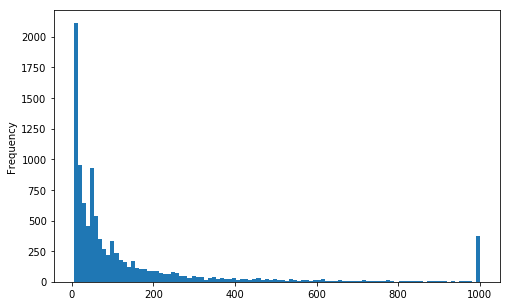

In [11]:
# outcome distribution after drop .transform(lambda x: np.log(x + 1))
y_train[(y_train >= 5).values].clip(0, 1000).plot('hist', bins=100, figsize=(8, 5))

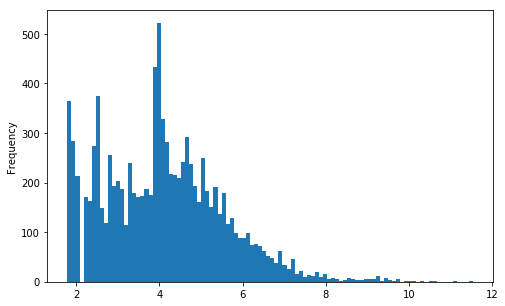

In [12]:
# outcome distribution after log transformation
# NOTE: we don't need to do log transform on target -- this is just for intepretation and visualization
y_train[(y_train >= 5).values].transform(lambda x: np.log(x + 1)).plot('hist', bins=100, figsize=(8, 5))

In [13]:
# down sample
samples_filter = (y_train >= 5).values
X_train = X_train[samples_filter]
y_train = y_train[samples_filter]

print(X_train.shape, X_test.shape)

(10044, 25) (5005, 25)


## correlation signals
We like to see if there is any linear correlation in features

In [14]:
# in-sample data correlation measure
data = pd.concat([X_train, y_train], axis=1).corr()
pd.DataFrame(data['claps'].sort_values(ascending=False))

,claps
claps,1.000000
claps_mean_by_author,0.825264
claps_median_by_author,0.808155
claps_min_by_author,0.705788
claps_max_by_author,0.620480
claps_mean_by_tags,0.417634
claps_median_by_tags,0.352582
claps_max_by_tags,0.128109
contents_stopword_count,0.121803
contents_total_word_count,0.115741


In [66]:
# out-of-sample data correlation measure
data = pd.concat([X_test, y_test], axis=1).corr()
pd.DataFrame(data['claps'].sort_values(ascending=False))

,claps
claps,1.000000
claps_median_by_author,0.841754
claps_mean_by_author,0.841641
claps_min_by_author,0.834938
claps_max_by_author,0.524422
claps_mean_by_tags,0.193915
headings_unique_word_count,0.114729
mins_read,0.107322
contents_unique_word_count,0.105874
headings_unusual_word_count,0.104277


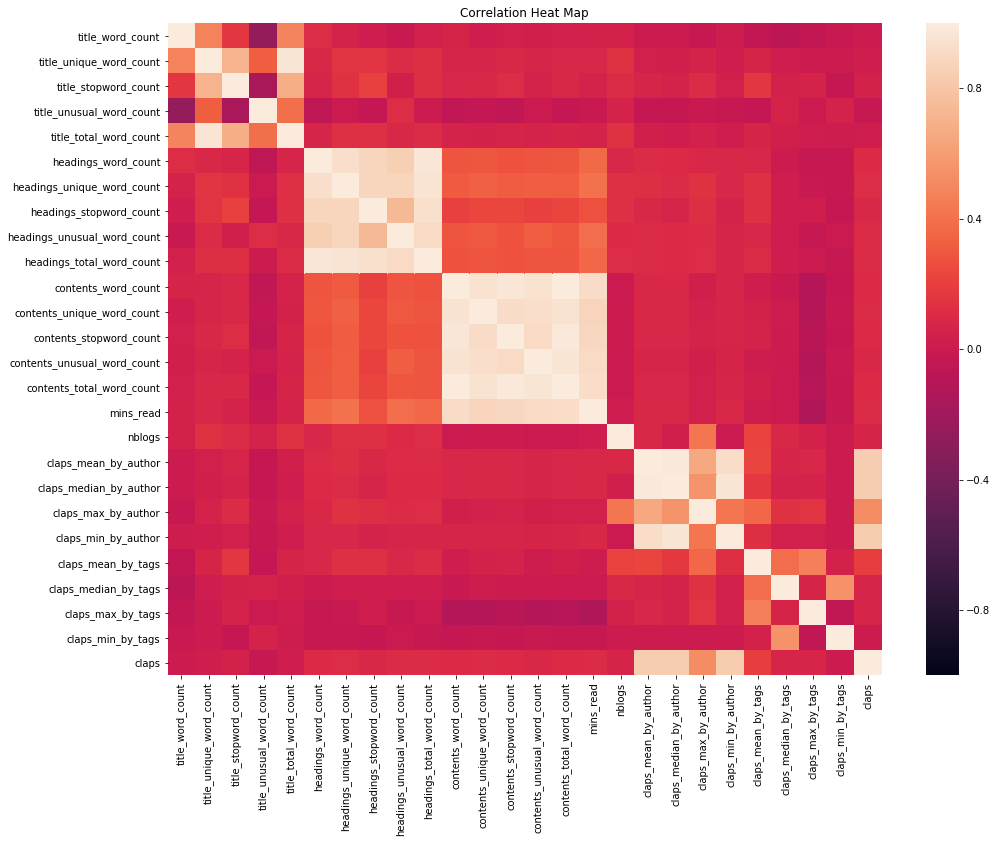

In [16]:
# heat map visual
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_title('Correlation Heat Map')
sns.heatmap(data ,vmin=-1, vmax=1, ax=ax)

## Observations:
1. target aggregated metric encoded by author profile ranks the top in terms of correlation
2. target aggregated metric encoded by tags ranks after
3. only title_unusual_word_count is negative correlated
4. most correlation still holds up for out-of-sample data

## Modeling Road Map
We will use linear models, tree models, MLP


1. Ridge
2. Lasso (check weights to confirm intuition)
3. Random Forest
4. Gradient Boosting Tree
5. MLP

#### NOTE: we don't have to standardize features before feeding into linear models. The reason for standardization is to improve convergence of gradient descent

In [17]:
# drop outliers
samples_filter = (y_train < 8e3).values

In [60]:
# 1. Ridge
ridge_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', RidgeCV(
            alphas=[1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 50.0],
            scoring='neg_mean_squared_error',
            cv=None,
            store_cv_values=True))
    ]
).fit(X_train[samples_filter], y_train[samples_filter])


# 2. Lasso
lasso_pipe = Pipeline(
    [
        ('t0', StandardScaler()),
        ('e0', LassoCV(
            n_alphas=100,
            cv=None,
            random_state=99))
    ]
).fit(X_train[samples_filter], y_train[samples_filter])


# 3. random forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=99
).fit(X_train[samples_filter], y_train[samples_filter])


# 4. gradient boosting tree
gbt = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    max_features=0.8,
    random_state=99
).fit(X_train[samples_filter], y_train[samples_filter])


# 5. multi-layers perceptron
mlp = MLPRegressor(
    random_state=99
).fit(X_train[samples_filter], y_train[samples_filter])

## features analysis

In [67]:
pd.DataFrame(
    {
        'features': X_train.columns.values,
        'corr_w_claps': data['claps'].loc[X_train.columns].values.round(3),
        'ridge_weights': ridge_pipe.steps[-1][-1].coef_.round(3),
        'lasso_weights': lasso_pipe.steps[-1][-1].coef_.round(3),
        'rf_feature_importances': rf.feature_importances_.round(3),
        'gbt_feature_importances': gbt.feature_importances_.round(3),
#         'mlp_avg_weights': mlp.coefs_[0].mean(axis=1).round(3),
    }
)

,features,corr_w_claps,ridge_weights,lasso_weights,rf_feature_importances,gbt_feature_importances
0,title_word_count,0.002,7.489,-0.000,0.003,0.004
1,title_unique_word_count,0.027,-26.326,-0.000,0.003,0.016
2,title_stopword_count,0.054,8.012,0.000,0.024,0.057
3,title_unusual_word_count,-0.017,0.629,-0.000,0.006,0.024
4,title_total_word_count,0.028,10.132,0.000,0.003,0.029
5,headings_word_count,0.098,-32.037,0.000,0.008,0.032
6,headings_unique_word_count,0.115,55.705,11.364,0.006,0.026
7,headings_stopword_count,0.086,-1.735,0.000,0.009,0.024
8,headings_unusual_word_count,0.104,7.272,0.000,0.005,0.073
9,headings_total_word_count,0.102,-9.330,0.000,0.005,0.023


## Observations
1. In most cases, model coef weight and features importances agree with pearson correlation between features and targets
2. We can see that Lasso model coef weights are easier for intepretation than Ridge. Lasso creates feature sparsity via L1 norm regularization. Features with zero weight are either highly correlated with other features or not statistiscally signficant
3. Random forest overweights features claps_mean_by_author and claps_median_by_author, which are highly correlated with each other. This may cause overfitting to training data
4. Gradient Boosting Tree shows similar features importances pattern like Random Forest, but it samples more features per tree than Random Forest, which is less proned to overfit specific features in insample data

## scoring

In [62]:
# prediction
ridge_pred = ridge_pipe.predict(X_test).clip(0,)
lasso_pred = lasso_pipe.predict(X_test).clip(0,)
rf_pred = rf.predict(X_test)
gbt_pred = gbt.predict(X_test)
mlp_pred = mlp.predict(X_test)

# rmse score
ridge_mse = (mean_squared_error(y_test, ridge_pred)).round(2)
lasso_mse = (mean_squared_error(y_test, lasso_pred)).round(2)
rf_mse = (mean_squared_error(y_test, rf_pred)).round(2)
gbt_mse = (mean_squared_error(y_test, gbt_pred)).round(2)
mlp_mse = (mean_squared_error(y_test, mlp_pred)).round(2)

# rmse score
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred)).round(2)
lasso_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred)).round(2)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred)).round(2)
gbt_rmse = np.sqrt(mean_squared_error(y_test, gbt_pred)).round(2)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred)).round(2)

In [63]:
pd.DataFrame(
    {
        'ridge': [ridge_rmse, ridge_mse],
        'lasso': [ridge_rmse, lasso_mse],
        'rf': [rf_rmse, rf_mse],
        'gbt': [gbt_rmse, gbt_mse],
        'mlp': [mlp_rmse, mlp_mse],
    },
    index=['rmse', 'mse']
)

,ridge,lasso,rf,gbt,mlp
rmse,578.35,578.35,875.94,869.00,613.57
mse,334489.33,329151.39,767269.54,755166.29,376472.48


## Conclusion
1. For regression problems, statistical models / linear models (ridege/lasso) outperforms tree models
2. Ridge and Lasso often arrives at similar performance in terms of error metrics. But Lasso provides better model intepretations
3. Linear model's performance are sensitive to high leverage samples / outlier samples
4. Tree model's performance are proned to overfit insample data if some features are highly correlated with target
5. MLP usually gives high performance, high accuracy, low mse, less proned to overfit data, but hard to explain
6. We made a huge improvement compared to baseline mse, specifically (663.75 - 578.70) / 663.75 = 13.7% error reduction

## Goodness of fit

In [64]:
# prep data for visualization
data = pd.DataFrame({'pred': lasso_pred,'true': y_test})
r2 = r2_score(y_pred=ridge_pred, y_true=y_test)
print('R squared of Lasso:', np.round(r2, 4))

R squared of Lasso: 0.7201


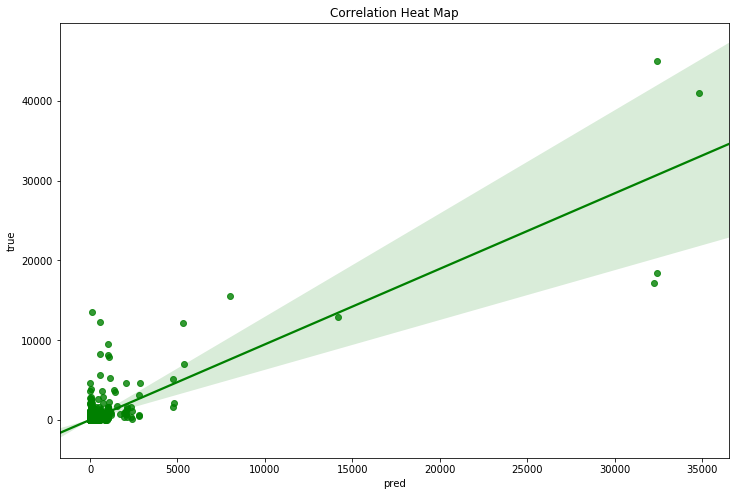

In [28]:
# 1. full regression plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Goodness of Fit')
ax = sns.regplot(x='pred', y='true', data=data, color="g", ax=ax)

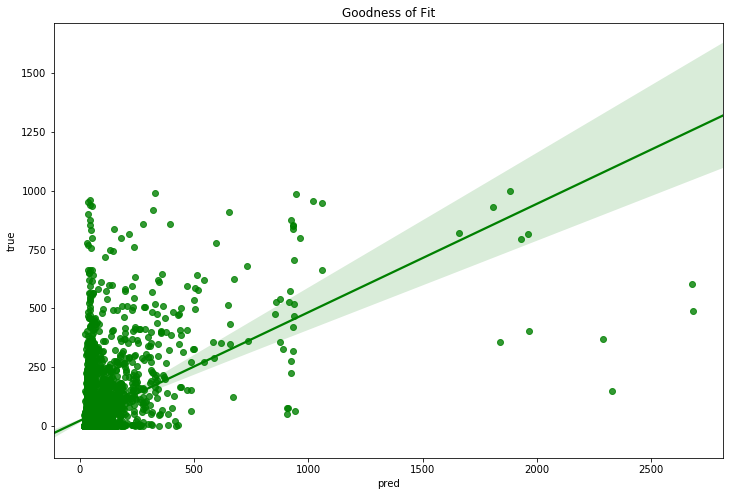

In [37]:
# 2. zoom in regression plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Goodness of Fit')
ax = sns.regplot(x='pred', y='true', data=data[data.true < 1e3], color="g", ax=ax)

/Users/Kevin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/Kevin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


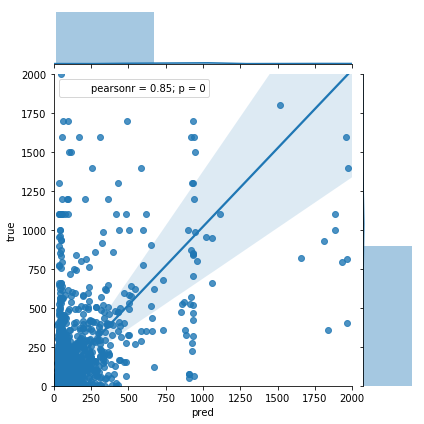

In [53]:
sns.jointplot(x='pred', y='true', data=data, kind="reg", xlim=(0, 2000), ylim=(0, 2000))

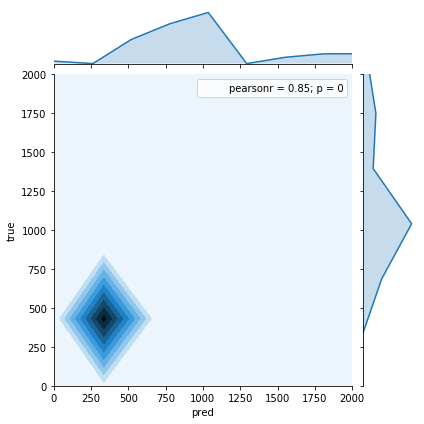

In [56]:
sns.jointplot(x='pred', y='true', data=data, kind="kde", xlim=(0, 2000), ylim=(0, 2000))

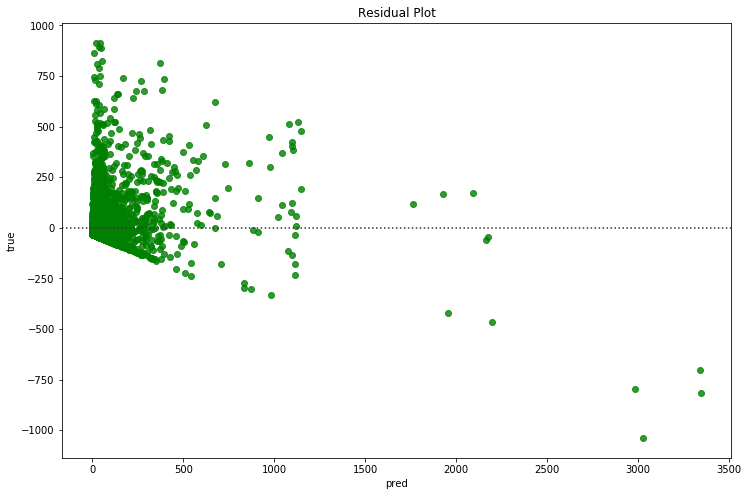

In [65]:
# 2. zoom in regression plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Residual Plot')
ax = sns.residplot(x='pred', y='true', data=data[data.true < 1e3], color="g", ax=ax)

## Fitness Observation
1. R squred of our Lasso model is 0.72, which means the model prediction explains 72% of variance explained
2. For blogs with high value of claps, lasso seems to under-predict claps, on the other hand, for blogs with low value of claps, lasso seems to over-predict claps, this could be the results of high-leverage samples and regularization
3. In residule plot, we can see that residules aren't iid normally distributed and there is clear cut in the lower part